In [42]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [43]:
#Load dataset
data = pd.read_csv('train.csv')

In [44]:
#Show first 5 rows
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [45]:
#Show data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [46]:
#Show summary statistics (mean, std, etc.)
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [47]:
#Count missing values in each column
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [48]:
#Fill missing values

data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])
data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].median())
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].median())
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].mode()[0])

In [49]:
#Remove extra spaces in string columns (if any)
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].map(lambda x: x.strip() if isinstance(x, str) else x)

In [50]:
#Replace '3+' in Dependents with 3 and convert to integer
data['Dependents'] = data['Dependents'].replace('3+', 3)
data['Dependents'] = data['Dependents'].astype(int)

In [51]:
#Create new features
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['EMI'] = data['LoanAmount'] / data['Loan_Amount_Term']
data['BalanceIncome'] = data['TotalIncome'] - data['EMI']

#Log transformations to reduce skewness
data['LoanAmount_log'] = np.log(data['LoanAmount'] + 1)
data['TotalIncome_log'] = np.log(data['TotalIncome'] + 1)

In [52]:
#Convert Loan_Status to readable form
data['Loan_Status'] = data['Loan_Status'].map({'Y': 'Approved', 'N': 'Rejected'})

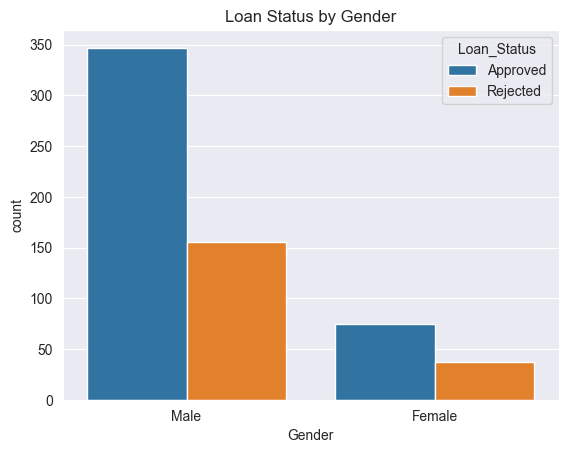

In [53]:
#Visualize loan approval by gender
sns.countplot(data=data, x='Gender', hue='Loan_Status')
plt.title('Loan Status by Gender')
plt.show()

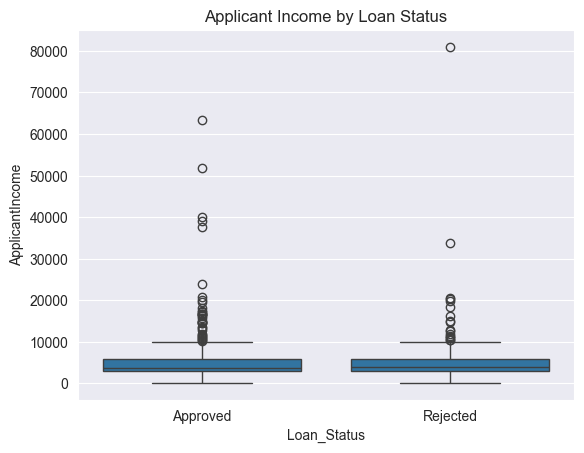

In [54]:
#Income comparison by loan status
sns.boxplot(data=data, x='Loan_Status', y='ApplicantIncome')
plt.title('Applicant Income by Loan Status')
plt.show()

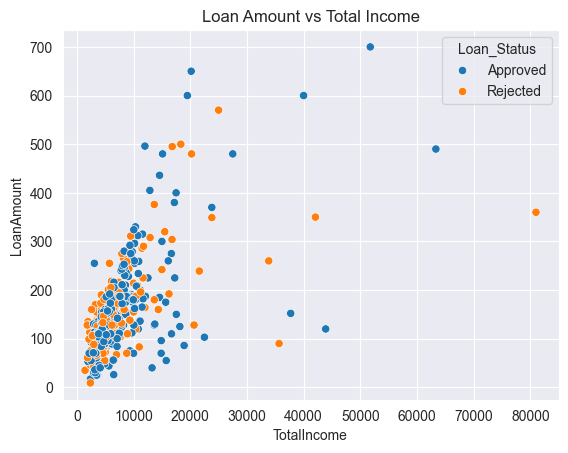

In [55]:
#Compare loan amount and income
sns.scatterplot(data=data, x='TotalIncome', y='LoanAmount', hue='Loan_Status')
plt.title('Loan Amount vs Total Income')
plt.show()

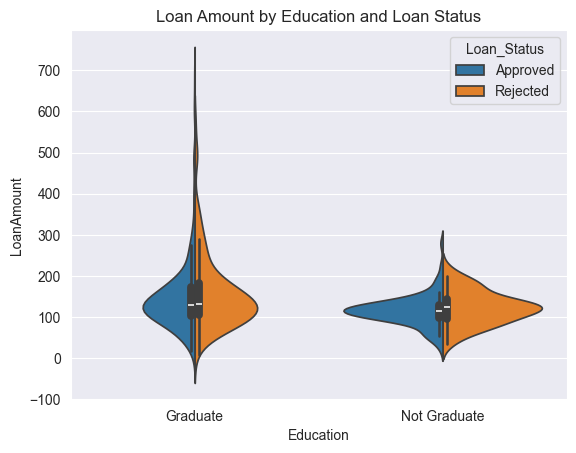

In [56]:
#Visualize loan amount by education and loan status
sns.violinplot(data=data, x='Education', y='LoanAmount', hue='Loan_Status', split=True)
plt.title('Loan Amount by Education and Loan Status')
plt.show()

In [57]:
#Encode categorical variables to numbers
le = LabelEncoder()
cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
for col in cols:
    data[col] = le.fit_transform(data[col])

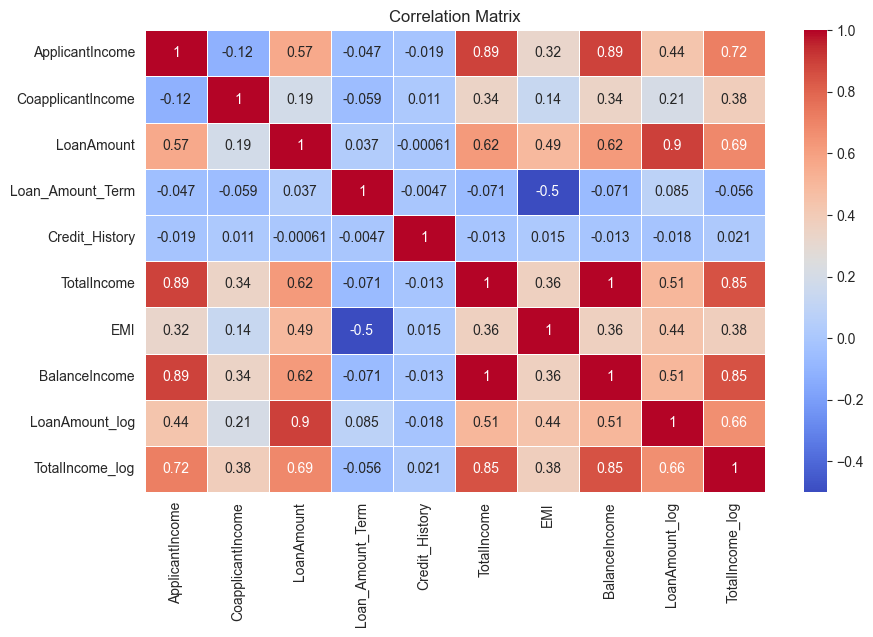

In [58]:
#Show correlation between numerical features
numeric_data = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [59]:
#Feature Selection and Target Variable
X = data.drop(columns=['Loan_ID', 'Loan_Status'])
y = data['Loan_Status']

# Replace original columns with log-transformed versions
X['LoanAmount'] = data['LoanAmount_log']
X['TotalIncome'] = data['TotalIncome_log']
X.drop(['LoanAmount_log', 'TotalIncome_log'], axis=1, inplace=True)

In [60]:
#Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [61]:
#Set hyperparameter options for Random Forest
param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'bootstrap': [True, False]
}

In [63]:
#Grid Search to find best parameters
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

#Best model from grid search
best_model = grid.best_estimator_

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [64]:
#Make predictions with Random Forest
y_pred = best_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

Random Forest Accuracy: 0.7886178861788617


In [65]:
#Train and test XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7398373983739838


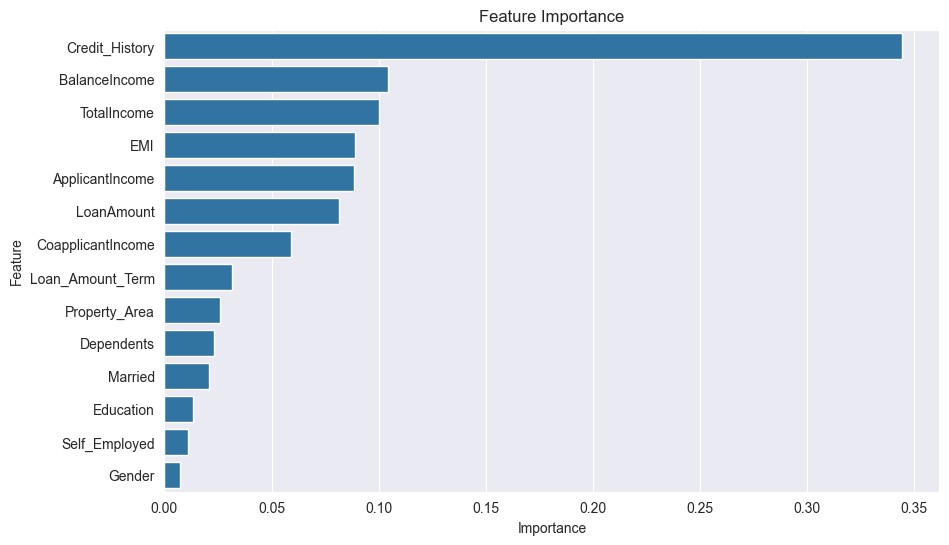

In [66]:
#Feature Importance from Random Forest

import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = best_model.feature_importances_
features = X.columns  # use actual feature variable
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()